In [2]:
import requests
from tqdm import tqdm
import zipfile
import os
import py7zr

# Download Part

In [16]:
# AD Dataset download script
url = "https://figshare.com/ndownloader/articles/27266262/versions/1"

output_path = "./AD.zip"

response = requests.get(url, stream=True)
total_size = int(response.headers.get('content-length', 0))  # 总大小（字节）

with open(output_path, "wb") as file, tqdm(
    desc=output_path,
    total=total_size,
    unit='B',
    unit_scale=True,
    unit_divisor=1024,
) as bar:
    for data in response.iter_content(chunk_size=1024):
        size = file.write(data)
        bar.update(size)

print("Download completed.")

./AD.zip: 100%|██████████| 420M/420M [00:45<00:00, 9.58MB/s]   

Download completed.


In [17]:
# AD Dataset unzip script
with zipfile.ZipFile(output_path, 'r') as zip_ref:
    zip_ref.extractall("./")
print("AD Dataset has been extracted, please check the Los_data folder.")

AD Dataset has been extracted, please check the Los_data folder.


In [18]:
# ED Dataset download script
url = "https://figshare.com/ndownloader/files/49844442"

output_path = "./ED.7z"

response = requests.get(url, stream=True)
total_size = int(response.headers.get('content-length', 0))  # 总大小（字节）

with open(output_path, "wb") as file, tqdm(
    desc=output_path,
    total=total_size,
    unit='B',
    unit_scale=True,
    unit_divisor=1024,
) as bar:
    for data in response.iter_content(chunk_size=1024):
        size = file.write(data)
        bar.update(size)

print("Download completed.")

./ED.7z: 100%|██████████| 831M/831M [01:32<00:00, 9.46MB/s]   

Download completed.


In [20]:
# ED Dataset unzip script
with py7zr.SevenZipFile('./ED.7z', mode='r') as archive:
    archive.extractall(path='./')
print("ED Dataset has been extracted, please check the StaticData folder.")

ED Dataset has been extracted, please check the StaticData folder.


# Read Data

In [3]:
import matplotlib.pyplot as plt
from mmrely import *
import numpy as np
import pickle
import glob
import pandas as pd

In [4]:
plt.rcParams['font.family'] = 'Times New Roman'

def awgn(signal, snr_db):
    if snr_db is None:
        return signal
    else:
        signal_power = np.mean(signal**2)
        snr_linear = 10 ** (snr_db / 10)
        noise_power = signal_power / snr_linear
        noise = np.random.normal(0, np.sqrt(noise_power), signal.shape)
        noisy_signal = signal + noise  
        noisy_signal = np.clip(noisy_signal, a_min=1e-10, a_max=None)  
        return noisy_signal

def db(rcs_data):
    return 10 * np.log10(rcs_data)

def save_pickle(obj, filename):
    try:
        with open(filename, 'wb') as file:
            pickle.dump(obj, file)
    except Exception as e:
        raise e

def load_pickle(filename):
    try:
        with open(filename, 'rb') as file:
            obj = pickle.load(file)
        return obj
    except Exception as e:
        print(f"Error occurred while loading pickle file: {e}")
        raise e

## Read LOS data

dict_keys(['LOS', 'Orbit_ID', 'Radar_ID', 'Target_ID'])


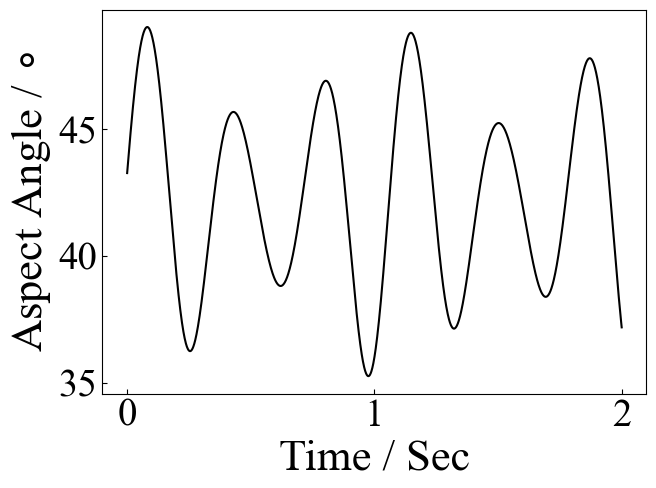

In [5]:
Train_data_0 = load_pickle('./Los_data/los_list_0.pkl')
instance_0 = Train_data_0[0]
print(instance_0.keys())

t = np.linspace(0, 2, 2048)
Los = instance_0['LOS']

plt.plot(t, Los, color='black')

ax = plt.gca()
ax.set_xticks([0, 1, 2])

fontsize = 32

ax.set_xlabel('Time / Sec', fontsize=fontsize)
ax.set_ylabel(r'Aspect Angle / $\circ$', fontsize=fontsize)

plt.tick_params(axis='both', which='major', labelsize=28)
ax.get_yaxis().get_offset_text().set_size(25)  # Adjust the size as needed


plt.tick_params(direction='in')

plt.subplots_adjust(left=0.1, right=0.95, top=0.95, bottom=0.15)

In [6]:
all_los_values = []

for i in range(4):
    # file_path = f'./Los_data/los_list_{i}.pkl'
    file_path = f'./Los_data/los_list_test_{i}.pkl'
    if not os.path.exists(file_path):
        print(f'文件 {file_path} 不存在，跳过')
        continue

    data = load_pickle(file_path)
    for instance in data:
        los = np.array(instance['LOS'])  # 转为np数组以便计算
        all_los_values.append(los)

all_los_array = np.concatenate(all_los_values)


min_val = np.min(all_los_array)
max_val = np.max(all_los_array)
mean_val = np.mean(all_los_array)
std_val = np.std(all_los_array)

print('LOS Value Statistics Across los_list_0.pkl to los_list_3.pkl:')
print(f'Minimum:  {min_val:.4f}')
print(f'Maximum:  {max_val:.4f}')
print(f'Mean:     {mean_val:.4f}')
print(f'Std Dev:  {std_val:.4f}')

LOS Value Statistics Across los_list_0.pkl to los_list_3.pkl:
Minimum:  61.4846
Maximum:  98.8712
Mean:     80.1425
Std Dev:  7.1246


## Read Static Data

In [7]:
CF_n = 10e9
target = 0

h_csv = f"./StaticData/{target}/H_{CF_n}Hz.csv" 
v_csv = f"./StaticData/{target}/V_{CF_n}Hz.csv" 
h_data = pd.read_csv(v_csv)
h_data.head(5)

,Frequency,Polarisation,Theta,Phi,Re(Etheta),Im(Etheta),Re(Ephi),Im(Ephi),RCS(Theta),RCS(Phi),RCS(Total)
0,1.000000e+10,0.0,29.00,0.0,0.010852,0.052669,-1.148834e-05,0.000205,0.036340,5.305494e-07,0.036341
1,1.000000e+10,0.0,29.01,0.0,0.013232,0.051556,6.110710e-07,0.000213,0.035601,5.705029e-07,0.035602
2,1.000000e+10,0.0,29.02,0.0,0.015643,0.050310,-4.736939e-05,0.000173,0.034882,4.063407e-07,0.034882
3,1.000000e+10,0.0,29.03,0.0,0.017911,0.049008,-1.241065e-05,0.000185,0.034213,4.316298e-07,0.034213
4,1.000000e+10,0.0,29.04,0.0,0.020150,0.047524,-5.861806e-05,0.000174,0.033483,4.237672e-07,0.033484


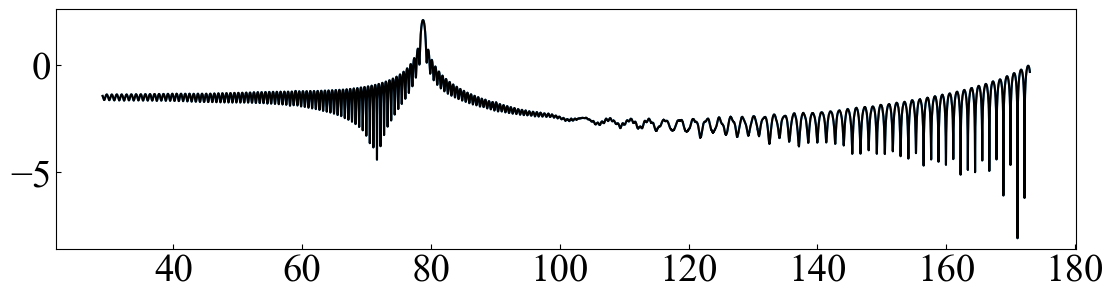

In [8]:
plt.figure(figsize=(12, 3))
theta = h_data["Theta"].values
# compute with formula
plt.plot(theta, np.log10(4*np.pi*np.abs(h_data["Re(Etheta)"].values + 1j * h_data["Im(Etheta)"].values)**2))
# Feko output
plt.plot(theta, np.log10(h_data["RCS(Theta)"]), color='k')

ax = plt.gca()
fontsize = 32

plt.tick_params(axis='both', which='major', labelsize=28)
ax.get_yaxis().get_offset_text().set_size(25)  # Adjust the size as needed

plt.tick_params(direction='in')

plt.subplots_adjust(left=0.1, right=0.95, top=0.95, bottom=0.15)

# Dateset Generation Example
For dataset generation, only the initial 0.5 seconds of each instance are utilized. Simulating full-schedule HRRP data for all instances would require no less than 170 GB of storage, whereas narrowband simulation reduces the storage demand to approximately 5 GB.

In [ ]:
# narrowband simulation, cost 15min except.
los_dir_list = glob.glob(r'./Los_data/*')

for los_pkl in los_dir_list:
    if 'test' in los_pkl:
        base_dir = 'test/'
    else:
        base_dir = 'train/'

    with open(los_pkl, 'rb') as file:
        los_list = pickle.load(file)

    for i, item in enumerate(tqdm(los_list, desc=f"Processing instances in {os.path.basename(los_pkl)}", leave=False)):
        data_dic = {}

        Data_dir = './Dataset/' + base_dir + str(item['Target_ID']) + '/'
        os.makedirs(Data_dir, exist_ok=True)

        data_dic['target_id'] = item['Target_ID']
        data_dic['los'] = item['LOS'][:512]
        data_dic['orbit_id'] = item['Orbit_ID']
        data_dic['radar_id'] = item['Radar_ID']

        echo_extractor = Echo(item['Target_ID'], item['LOS'][:512])
        data_dic['echo'], _ = echo_extractor.get_echo()

        # 预留 HRRP 数据字段
        data_dic['hrrp'] = None

        with open(os.path.join(Data_dir, f"{i}.pkl"), 'wb') as f:
            pickle.dump(data_dic, f)
    #     break
    # break

In [ ]:
# wideband simulation, cost 27min except.
dataset_dirs = ['./Dataset/train', './Dataset/test']
pkl_paths = []

for base_dir in dataset_dirs:
    for root, _, files in os.walk(base_dir):
        for file in files:
            if file.endswith('.pkl'):
                pkl_paths.append(os.path.join(root, file))

interpolation_dict_cache = {}

# 使用 tqdm 监控进度
for path in tqdm(pkl_paths, desc='Updating HRRP'):
    try:
        instance = load_pickle(path)
        if instance['hrrp'] is not None:
            continue  

        target_id = instance['target_id']
        los_angles = instance['los']

        # 如果该 target_id 没处理过，就计算一次 static_hrrp 和 interpolation_dict
        if target_id not in interpolation_dict_cache:
            static_hrrp, theta, frequencies = extract_static(target_id)
            interpolation_dict = create_interpolation_dict(static_hrrp, theta)
            interpolation_dict_cache[target_id] = interpolation_dict
        else:
            interpolation_dict = interpolation_dict_cache[target_id]

        # 提取 HRRP 并更新
        hrrp_values = extract_hrrp(interpolation_dict, los_angles)
        instance['hrrp'] = hrrp_values
        save_pickle(instance, path)

    except Exception as e:
        print(f'❌ Error occurred: {e} at {path}')

Updating HRRP: 100%|██████████| 26800/26800 [27:25<00:00, 16.28it/s]  


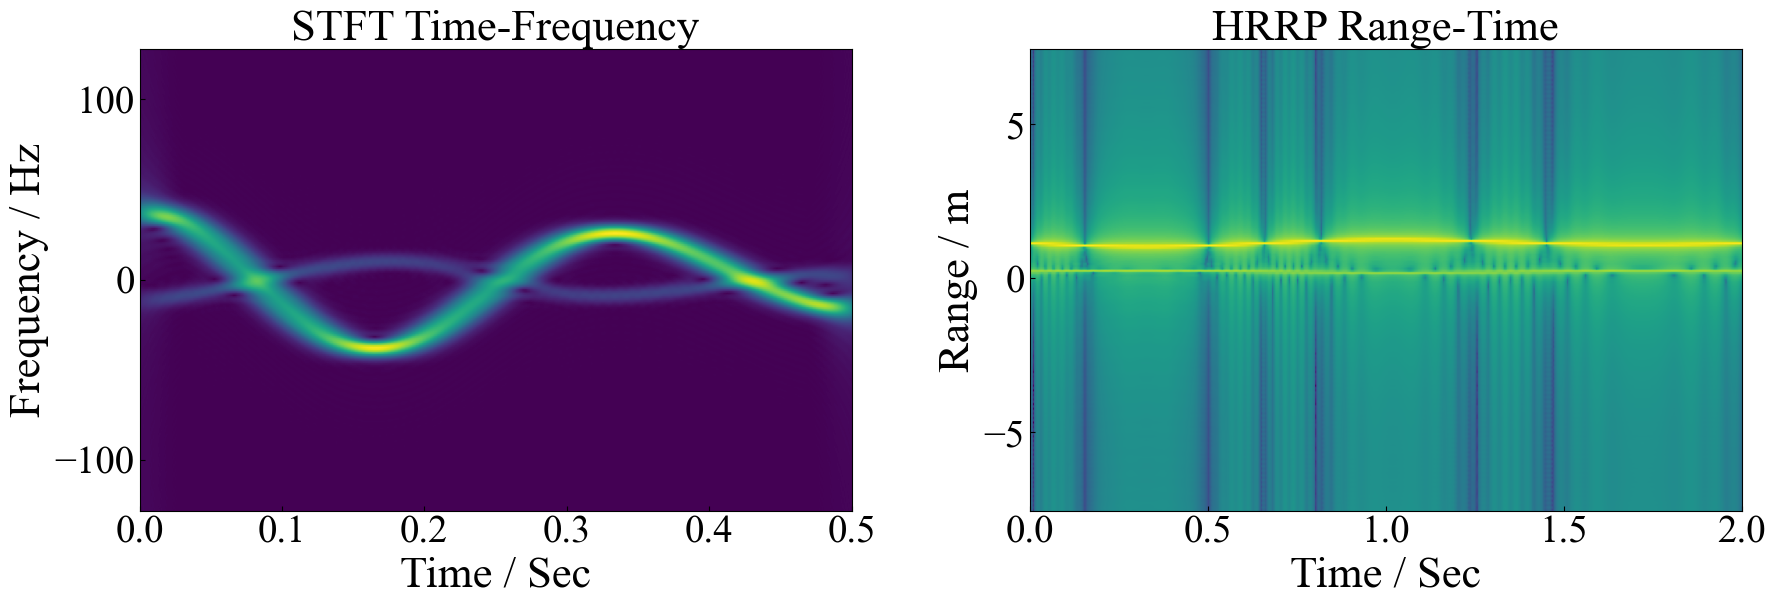

In [32]:
# 数据准备
instance_0 = load_pickle('./Dataset/train/0/0.pkl')
pol = 'HH'
instance_0_baseband = instance_0['echo'][pol]
instance_0_hrrps = instance_0['hrrp'][pol]

# HRRP参数
c = 3e8
f_c = 9e9
B = 2e9
dr = c / (2 * B)
x = np.arange(0, dr * 201, dr) - dr * 201 / 2

# HRRP反变换
hrrp = fftshift(ifft(instance_0_hrrps, axis=0), axes=0)
hrrp = np.log10(np.abs(hrrp))

# STFT 计算
tf = STFT(instance_0_baseband)

# 绘图
fig, axes = plt.subplots(1, 2, figsize=(18, 6))  # 横向排列两个子图
fontsize = 32

# 子图 1：STFT
axes[0].imshow(np.abs(tf), aspect='auto', extent=[0, 0.5, -128, 128])
axes[0].set_title('STFT Time-Frequency', fontsize=fontsize)
axes[0].set_xlabel('Time / Sec', fontsize=fontsize)
axes[0].set_ylabel('Frequency / Hz', fontsize=fontsize)
axes[0].tick_params(axis='both', which='major', labelsize=28)
axes[0].tick_params(direction='in')

# 子图 2：HRRP Range-Time
axes[1].imshow(hrrp, extent=[0, 2, x[0], x[-1]], aspect='auto')
axes[1].set_title('HRRP Range-Time', fontsize=fontsize)
axes[1].set_xlabel('Time / Sec', fontsize=fontsize)
axes[1].set_ylabel('Range / m', fontsize=fontsize)
axes[1].tick_params(axis='both', which='major', labelsize=28)
axes[1].tick_params(direction='in')

# 布局调整
plt.subplots_adjust(left=0.08, right=0.97, top=0.92, bottom=0.15, wspace=0.25)
plt.show()